# **1. AGCN Install Dependencies**

In [ ]:
# Cell 1: Install PyTorch, tensorboardX, tqdm, yaml
!pip install torch torchvision torchaudio
!pip install tensorboardX tqdm pyyaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
!pip install torch torchvision torchaudio tqdm scikit-learn matplotlib tensorboardX --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Set Paths & Check Files**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from torchsummary import summary


In [ ]:
import numpy as np
import pickle
import os

# Data/label locations (edit for X-View or bone if needed)
train_data = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
val_data   = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Check files exist
print("Train data:", os.path.exists(train_data), "| Val data:", os.path.exists(val_data))
print("Train label:", os.path.exists(train_label), "| Val label:", os.path.exists(val_label))

# Print label counts and a sample
with open(train_label, 'rb') as f:
    sample_names, sample_labels = pickle.load(f)
print(f"Train samples: {len(sample_labels)} | Example label: {sample_labels[0]}")
with open(val_label, 'rb') as f:
    val_names, val_labels = pickle.load(f)
print(f"Val samples: {len(val_labels)} | Example label: {val_labels[0]}")

# Print one data sample shape
sample = np.load(train_data, mmap_mode='r')
print("Train data shape (N,C,T,V,M):", sample.shape)
print("One sample min/max:", sample[0].min(), sample[0].max())


Train data: True | Val data: True
Train label: True | Val label: True
Train samples: 33383 | Example label: 16
Val samples: 23327 | Example label: 13
Train data shape (N,C,T,V,M): (33383, 3, 300, 25, 2)
One sample min/max: -1.9420302618199796 0.8381361333212642


In [ ]:
print("Unique classes in train:", len(set(sample_labels)))
print("Unique classes in val:", len(set(val_labels)))


Unique classes in train: 60
Unique classes in val: 60


# **Set Reproducibility**

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


# **Feeder Dataset Class**

In [ ]:
class Feeder(Dataset):
    def __init__(self, data_path, label_path, debug=False, use_mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.use_mmap = use_mmap
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            try:
                self.sample_name, self.label = pickle.load(f)
            except:
                self.sample_name, self.label = pickle.load(f, encoding='latin1')
        if self.use_mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)
        if self.debug:
            self.label = self.label[:100]
            self.data = self.data[:100]
            self.sample_name = self.sample_name[:100]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], idx


# **AGCN Model (Official, Standalone)**

In [ ]:
# Cell 9: Official AGCN Model (direct copy from your file, adapted for cell)
import torch
import torch.nn as nn
import math
import numpy as np

def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, num_subset=3):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        nn.init.constant_(self.PA, 1e-6)
        self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        self.num_subset = num_subset
        self.conv_a = nn.ModuleList()
        self.conv_b = nn.ModuleList()
        self.conv_d = nn.ModuleList()
        for i in range(self.num_subset):
            self.conv_a.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_b.append(nn.Conv2d(in_channels, inter_channels, 1))
            self.conv_d.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.soft = nn.Softmax(-2)
        self.relu = nn.ReLU(inplace=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.conv_d[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        A = self.A.to(x.device) + self.PA
        y = None
        for i in range(self.num_subset):
            A1 = self.conv_a[i](x).permute(0, 3, 1, 2).contiguous().view(N, V, self.inter_c * T)
            A2 = self.conv_b[i](x).view(N, self.inter_c * T, V)
            A1 = self.soft(torch.matmul(A1, A2) / A1.size(-1))  # N V V
            A1 = A1 + A[i]
            A2 = x.view(N, C * T, V)
            z = self.conv_d[i](torch.matmul(A2, A1).view(N, C, T, V))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        x = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(x)

class Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, graph=None, graph_args=dict(), in_channels=3):
        super(Model, self).__init__()
        class Graph:
            def __init__(self, labeling_mode='spatial'):
                self.num_node = 25
                self.self_link = [(i, i) for i in range(self.num_node)]
                inward_ori_index = [
                    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
                    (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
                    (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
                    (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
                ]
                inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
                outward = [(j, i) for (i, j) in inward]
                neighbor = inward + outward
                def edge2mat(link, num_node):
                    A = np.zeros((num_node, num_node))
                    for i, j in link:
                        A[j, i] = 1
                    return A
                def normalize_digraph(A):
                    Dl = np.sum(A, 0)
                    h, w = A.shape
                    Dn = np.zeros((w, w))
                    for i in range(w):
                        if Dl[i] > 0:
                            Dn[i, i] = Dl[i] ** (-1)
                    AD = np.dot(A, Dn)
                    return AD
                def get_spatial_graph(num_node, self_link, inward, outward):
                    I = edge2mat(self_link, num_node)
                    In = normalize_digraph(edge2mat(inward, num_node))
                    Out = normalize_digraph(edge2mat(outward, num_node))
                    A = np.stack((I, In, Out))
                    return A
                self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)
        GraphObj = Graph(**graph_args)
        A = GraphObj.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False)
        self.l2 = TCN_GCN_unit(64, 64, A)
        self.l3 = TCN_GCN_unit(64, 64, A)
        self.l4 = TCN_GCN_unit(64, 64, A)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2)
        self.l6 = TCN_GCN_unit(128, 128, A)
        self.l7 = TCN_GCN_unit(128, 128, A)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2)
        self.l9 = TCN_GCN_unit(256, 256, A)
        self.l10 = TCN_GCN_unit(256, 256, A)
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        return self.fc(x)


In [ ]:
!pip install torchinfo --quiet

In [ ]:
from torchinfo import summary
import torch

BATCH_SIZE = 64  # Same as your training cell
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dummy_input_size = (BATCH_SIZE, 3, 300, 25, 2)  # (batch, C, T, V, M)

model = AGCN(num_class=60, num_point=25, num_person=2).to(DEVICE)

summary(model, input_size=dummy_input_size, device=str(DEVICE))

Layer (type:depth-idx)                   Output Shape              Param #
AGCN                                     [64, 60]                  --
├─BatchNorm1d: 1-1                       [64, 150, 300]            300
├─TCN_GCN_unit: 1-2                      [128, 64, 300, 25]        --
│    └─unit_gcn: 2-1                     [128, 64, 300, 25]        1,875
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-3                 [128, 25, 25]             --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9              --                        (recursive)
│    │    └─ModuleList: 3-10             --                        (recursive)
│    │    └─Softmax: 3-7                 [128, 25, 25]             --
│    │    └─ModuleList: 3-12             --                        (recursive)
│    │    └─ModuleList: 3-9

In [ ]:
import numpy as np
import pickle
import os

# Example: print shape and label count for X-Sub
# Corrected paths based on previous cell definitions
train_data_path = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
train_label_path = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
val_data_path = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
val_label_path = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'


data = np.load(train_data_path, mmap_mode='r')
with open(train_label_path, 'rb') as f:
    names, labels = pickle.load(f)
print("Train data shape:", data.shape)
print("Number of train samples:", len(labels))
print("Label min/max:", min(labels), max(labels))

data_val = np.load(val_data_path, mmap_mode='r')
with open(val_label_path, 'rb') as f:
    names_val, labels_val = pickle.load(f)
print("Val data shape:", data_val.shape)
print("Number of val samples:", len(labels_val))
print("Val label min/max:", min(labels_val), max(labels_val))

Train data shape: (33383, 3, 300, 25, 2)
Number of train samples: 33383
Label min/max: 0 59
Val data shape: (23327, 3, 300, 25, 2)
Number of val samples: 23327
Val label min/max: 0 59


# **Training + Validation (Save Best Model)**

In [ ]:
def train_and_evaluate_agcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=64, epochs=65, patience=13, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_set = Feeder(train_data_path, train_label_path)
    val_set = Feeder(val_data_path, val_label_path)

    # Custom collate function to handle non-writable numpy arrays
    def custom_collate(batch):
        data = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        # Explicitly copy data before converting to tensor
        data = torch.stack([torch.from_numpy(np.copy(d)) for d in data], 0)
        labels = torch.LongTensor(labels)
        return data, labels

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

    model = Model(num_class=60, num_point=25, num_person=2).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for data, label in train_loader:
            data, label = data.to(DEVICE).float(), label.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE).float(), label.to(DEVICE)
                outputs = model(data)
                loss = criterion(outputs, label)
                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.2f}s | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch+1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")
    # Plotting (optional)
    if plot_prefix:
        plt.figure(figsize=(8,4))
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title(f'Accuracy: {plot_prefix}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    return best_acc, best_epoch, history, model, val_loader

# **AGCN - X-Sub Result**

Training on X-Sub...
Epoch  1/65 | Time: 512.20s | Train Loss: 3.2266 Acc: 0.1354 | Val Loss: 2.4881 Acc: 0.2532
Epoch  2/65 | Time: 512.99s | Train Loss: 2.0949 Acc: 0.3730 | Val Loss: 1.8275 Acc: 0.4517
Epoch  3/65 | Time: 512.63s | Train Loss: 1.6186 Acc: 0.5080 | Val Loss: 1.4834 Acc: 0.5586
Epoch  4/65 | Time: 512.87s | Train Loss: 1.3343 Acc: 0.5943 | Val Loss: 1.3197 Acc: 0.6039
Epoch  5/65 | Time: 512.59s | Train Loss: 1.1417 Acc: 0.6532 | Val Loss: 1.0635 Acc: 0.6824
Epoch  6/65 | Time: 512.46s | Train Loss: 0.9946 Acc: 0.6961 | Val Loss: 0.9636 Acc: 0.7062
Epoch  7/65 | Time: 512.58s | Train Loss: 0.8882 Acc: 0.7273 | Val Loss: 0.9387 Acc: 0.7220
Epoch  8/65 | Time: 512.47s | Train Loss: 0.8129 Acc: 0.7491 | Val Loss: 0.9254 Acc: 0.7242
Epoch  9/65 | Time: 513.02s | Train Loss: 0.7517 Acc: 0.7652 | Val Loss: 0.8127 Acc: 0.7551
Epoch 10/65 | Time: 512.12s | Train Loss: 0.7013 Acc: 0.7821 | Val Loss: 0.8472 Acc: 0.7431
Epoch 11/65 | Time: 512.21s | Train Loss: 0.6506 Acc: 0.797

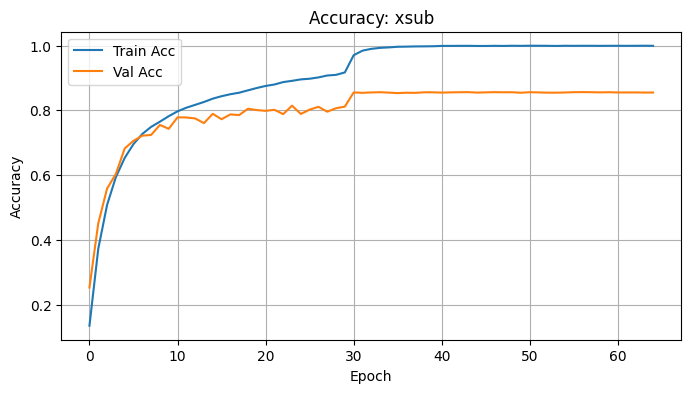

ValueError: too many values to unpack (expected 3)

In [ ]:
# X-Sub paths
Xsub_train_data  = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data    = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'


# X-Sub training
print("Training on X-Sub...")
xsub_best_acc, xsub_best_epoch, xsub_history = train_and_evaluate_agcn(
    Xsub_train_data, Xsub_train_label, Xsub_val_data, Xsub_val_label,
    save_path='/content/best_agcn_xsub.pth', batch_size=64, epochs=65, patience=13, plot_prefix='xsub'
)
print(f"\n[X-Sub] Best Val Acc: {xsub_best_acc:.4f} at Epoch {xsub_best_epoch}\n{'='*60}\n")

# **AGCN Result X-View**

Training on X-View...
Epoch  1/65 | Time: 551.96s | Train Loss: 3.2389 Acc: 0.1318 | Val Loss: 2.5943 Acc: 0.2461
Epoch  2/65 | Time: 550.78s | Train Loss: 2.1120 Acc: 0.3633 | Val Loss: 1.7894 Acc: 0.4327
Epoch  3/65 | Time: 550.63s | Train Loss: 1.5546 Acc: 0.5278 | Val Loss: 1.4145 Acc: 0.5695
Epoch  4/65 | Time: 549.93s | Train Loss: 1.2379 Acc: 0.6234 | Val Loss: 1.0735 Acc: 0.6741
Epoch  5/65 | Time: 550.50s | Train Loss: 1.0494 Acc: 0.6800 | Val Loss: 1.0635 Acc: 0.6823
Epoch  6/65 | Time: 550.48s | Train Loss: 0.9256 Acc: 0.7147 | Val Loss: 1.0193 Acc: 0.6915
Epoch  7/65 | Time: 550.53s | Train Loss: 0.8269 Acc: 0.7466 | Val Loss: 0.8568 Acc: 0.7381
Epoch  8/65 | Time: 550.85s | Train Loss: 0.7507 Acc: 0.7658 | Val Loss: 0.8488 Acc: 0.7434
Epoch  9/65 | Time: 551.26s | Train Loss: 0.6847 Acc: 0.7865 | Val Loss: 0.7579 Acc: 0.7758
Epoch 10/65 | Time: 549.96s | Train Loss: 0.6466 Acc: 0.7941 | Val Loss: 0.7810 Acc: 0.7604
Epoch 11/65 | Time: 550.47s | Train Loss: 0.6036 Acc: 0.81

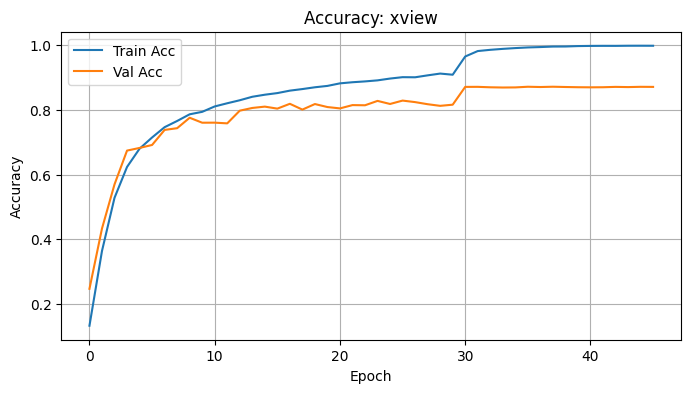


[X-View] Best Val Acc: 0.8718 at Epoch 38



In [ ]:

# X-View paths
Xview_train_data  = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data    = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label   = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'# X-View training


# Train X-View
print("Training on X-View...")
xview_best_acc, xview_best_epoch, xview_history, xview_model, xview_val_loader = train_and_evaluate_agcn(
    Xview_train_data, Xview_train_label, Xview_val_data, Xview_val_label,
    save_path='/content/best_agcn_xview.pth', batch_size=64, epochs=65, patience=8, plot_prefix='xview'
)
print(f"\n[X-View] Best Val Acc: {xview_best_acc:.4f} at Epoch {xview_best_epoch}\n{'='*60}\n")

# **Metrics & Confusion Matrix & Model Summary**

# **AGCN- V-VIEW GRAPH**

<Figure size 1200x1200 with 0 Axes>

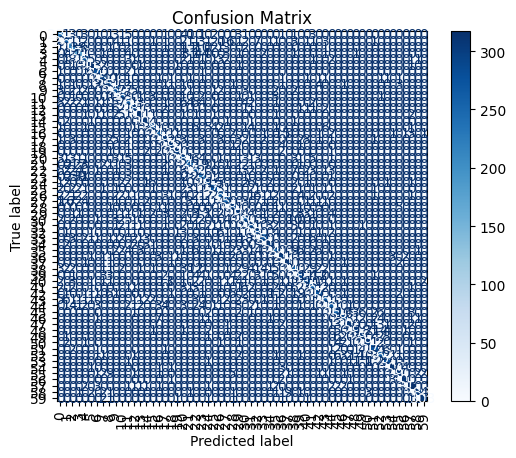

              precision    recall  f1-score   support

           0     0.8410    0.8410    0.8410       283
           1     0.8497    0.8150    0.8320       319
           2     0.5917    0.7196    0.6494       296
           3     0.5986    0.5556    0.5763       306
           4     0.8642    0.8847    0.8744       295
           5     0.9313    0.9659    0.9483       323
           6     0.9236    0.9586    0.9408       290
           7     0.8082    0.8290    0.8185       310
           8     0.7805    0.8076    0.7938       317
           9     0.8226    0.8706    0.8459       309
          10     0.8725    0.8841    0.8783       302
          11     0.7745    0.8031    0.7885       325
          12     0.9199    0.9379    0.9288       306
          13     0.9443    0.9414    0.9428       324
          14     0.9448    0.9655    0.9550       319
          15     0.9221    0.8847    0.9030       321
          16     0.9030    0.8864    0.8946       273
          17     0.8769    

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Use the save_path, model, and data loader from the successful X-View training
save_path = '/content/best_agcn_xview.pth' # Assuming you want to evaluate the X-View model
model = xview_model # Use the model trained on X-View
val_loader = xview_val_loader # Use the validation loader for X-View
device = DEVICE # Use the device defined earlier

model.load_state_dict(torch.load(save_path))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device).float(), label.to(device)  # Explicitly convert data to float
        outputs = model(data)
        all_preds.append(outputs.cpu())
        all_labels.append(label.cpu())
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
pred_classes = all_preds.argmax(1)

# Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# Metrics
print(classification_report(all_labels, pred_classes, digits=4))
TP = np.diag(cm)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (FP + FN + TP)
sensitivity = (TP / (TP + FN + 1e-10)).mean()
specificity = (TN / (TN + FP + 1e-10)).mean()
print(f"Sensitivity (Recall macro): {sensitivity:.4f}")
print(f"Specificity (macro): {specificity:.4f}")

# Macro AUC-ROC
try:
    proba = torch.softmax(all_preds, dim=1).numpy()
    auc = roc_auc_score(all_labels.numpy(), proba, multi_class='ovr', average='macro')
    print("AUC-ROC Score (macro):", auc)
except Exception as e:
    print("AUC-ROC not available:", e)

# Model summary
from torchsummary import summary
summary(model, input_size=(3, 300, 25, 2), device='cuda')

# **AGCN X-SUB RESULT GRAPH**

In [ ]:
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader

# Feeder definition (as before)
class Feeder(Dataset):
    def __init__(self, data_path, label_path, debug=False, use_mmap=True):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.use_mmap = use_mmap
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            try:
                self.sample_name, self.label = pickle.load(f)
            except:
                self.sample_name, self.label = pickle.load(f, encoding='latin1')
        if self.use_mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)
        if self.debug:
            self.label = self.label[:100]
            self.data = self.data[:100]
            self.sample_name = self.sample_name[:100]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx], idx

# X-Sub validation paths
Xsub_val_data    = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# Create DataLoader
xsub_val_set = Feeder(Xsub_val_data, Xsub_val_label)
xsub_val_loader = DataLoader(xsub_val_set, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
# Paste your Model class here if not already in memory

# Recreate and load model weights
xsub_model = Model(num_class=60, num_point=25, num_person=2).to('cuda')
xsub_model.load_state_dict(torch.load('/content/best_agcn_xsub.pth'))
xsub_model.eval()


Model(
  (data_bn): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): TCN_GCN_unit(
    (gcn1): unit_gcn(
      (conv_a): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_b): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_d): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (soft): Softmax(dim=-2)
      (relu): ReLU(inplace=True)
    )
    (tcn1): unit_tcn(
      (conv): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of t

<Figure size 1200x1200 with 0 Axes>

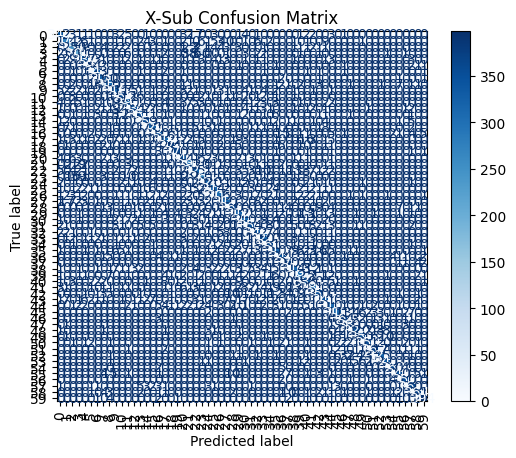

              precision    recall  f1-score   support

           0     0.8872    0.8543    0.8704       405
           1     0.8424    0.7258    0.7798       383
           2     0.6228    0.6403    0.6314       392
           3     0.5675    0.5407    0.5538       381
           4     0.8779    0.8667    0.8723       390
           5     0.9128    0.9660    0.9387       412
           6     0.9158    0.9305    0.9231       374
           7     0.7629    0.8270    0.7937       393
           8     0.7347    0.7786    0.7560       402
           9     0.8154    0.8281    0.8217       384
          10     0.8680    0.8831    0.8755       402
          11     0.7766    0.8022    0.7892       364
          12     0.9443    0.8782    0.9101       386
          13     0.9005    0.9005    0.9005       392
          14     0.9323    0.9109    0.9215       393
          15     0.8700    0.8794    0.8747       373
          16     0.9098    0.8810    0.8952       378
          17     0.8635    

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_preds, all_labels = [], []
with torch.no_grad():
    for data, label, _ in xsub_val_loader:
        data, label = data.to(device).float(), label.to(device)
        outputs = xsub_model(data)
        all_preds.append(outputs.cpu())
        all_labels.append(label.cpu())
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
pred_classes = all_preds.argmax(1)

# Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap='Blues', xticks_rotation=90)
plt.title("X-Sub Confusion Matrix")
plt.show()

# Metrics
print(classification_report(all_labels, pred_classes, digits=4))
TP = np.diag(cm)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (FP + FN + TP)
sensitivity = (TP / (TP + FN + 1e-10)).mean()
specificity = (TN / (TN + FP + 1e-10)).mean()
print(f"Sensitivity (Recall macro): {sensitivity:.4f}")
print(f"Specificity (macro): {specificity:.4f}")

# Macro AUC-ROC
try:
    proba = torch.softmax(all_preds, dim=1).numpy()
    auc = roc_auc_score(all_labels.numpy(), proba, multi_class='ovr', average='macro')
    print("AUC-ROC Score (macro):", auc)
except Exception as e:
    print("AUC-ROC not available:", e)

summary(xsub_model, input_size=(3, 300, 25, 2), device='cuda')


# **2. CTRGCN- Lion Optmizer**

In [ ]:
!pip install lion-pytorch

In [ ]:
!pip install torch torchvision torchaudio
!pip install einops  # Required for CTR-GCN official
!pip install tensorboardX tqdm pyyaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)


# **Prepare DataLoader Class (Feeder)**

In [ ]:
# CTR-GCN Graph Class (NTU)
import numpy as np

class NTUGraph:
    def __init__(self, labeling_mode='spatial'):
        self.num_node = 25
        self.self_link = [(i, i) for i in range(self.num_node)]
        inward_ori_index = [
            (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5), (7, 6),
            (8, 7), (9, 21), (10, 9), (11, 10), (12, 11), (13, 1),
            (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), (19, 18),
            (20, 19), (22, 23), (23, 8), (24, 25), (25, 12)
        ]
        inward = [(i - 1, j - 1) for (i, j) in inward_ori_index]
        outward = [(j, i) for (i, j) in inward]
        neighbor = inward + outward

        def edge2mat(link, num_node):
            A = np.zeros((num_node, num_node))
            for i, j in link:
                A[j, i] = 1
            return A

        def normalize_digraph(A):
            Dl = np.sum(A, 0)
            h, w = A.shape
            Dn = np.zeros((w, w))
            for i in range(w):
                if Dl[i] > 0:
                    Dn[i, i] = Dl[i] ** (-1)
            AD = np.dot(A, Dn)
            return AD

        def get_spatial_graph(num_node, self_link, inward, outward):
            I = edge2mat(self_link, num_node)
            In = normalize_digraph(edge2mat(inward, num_node))
            Out = normalize_digraph(edge2mat(outward, num_node))
            A = np.stack((I, In, Out))
            return A

        self.A = get_spatial_graph(self.num_node, self.self_link, inward, outward)


In [ ]:
# Cell 3.2: CTR-GCN Model Helper Functions and Building Blocks
import torch
import torch.nn as nn
import math

# Initialization utilities (official)
def conv_branch_init(conv, branches):
    weight = conv.weight
    n = weight.size(0)
    k1 = weight.size(1)
    k2 = weight.size(2)
    nn.init.normal_(weight, 0, math.sqrt(2. / (n * k1 * k2 * branches)))
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0)

def conv_init(conv):
    if conv.weight is not None:
        nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0)

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)

# Official unit_gcn block (adaptive PA)
class unit_gcn(nn.Module):
    def __init__(self, in_channels, out_channels, A, coff_embedding=4, adaptive=True, residual=True):
        super(unit_gcn, self).__init__()
        inter_channels = out_channels // coff_embedding
        self.inter_c = inter_channels
        self.out_c = out_channels
        self.in_c = in_channels
        self.adaptive = adaptive
        self.num_subset = A.shape[0]
        self.convs = nn.ModuleList()
        for i in range(self.num_subset):
            self.convs.append(nn.Conv2d(in_channels, out_channels, 1))
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = lambda x: x
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        if self.adaptive:
            self.PA = nn.Parameter(torch.from_numpy(A.astype(np.float32)))
        else:
            self.A = torch.tensor(A.astype(np.float32), requires_grad=False)
        bn_init(self.bn, 1e-6)
        for i in range(self.num_subset):
            conv_branch_init(self.convs[i], self.num_subset)
    def forward(self, x):
        N, C, T, V = x.size()
        if self.adaptive:
            A = self.PA
        else:
            A = self.A.to(x.device)
        y = None
        for i in range(self.num_subset):
            A1 = A[i]
            z = self.convs[i](torch.einsum('nctv,vw->nctw', (x, A1)))
            y = z + y if y is not None else z
        y = self.bn(y)
        y += self.down(x)
        return self.relu(y)

# Official unit_tcn block (1D temporal conv)
class unit_tcn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(unit_tcn, self).__init__()
        pad = int((kernel_size - 1) / 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                              stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        conv_init(self.conv)
        bn_init(self.bn, 1)
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

# Official TCN+GCN unit (residual block)
class TCN_GCN_unit(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True, adaptive=True):
        super(TCN_GCN_unit, self).__init__()
        self.gcn1 = unit_gcn(in_channels, out_channels, A, adaptive=adaptive)
        self.tcn1 = unit_tcn(out_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if not residual:
            self.residual = lambda x: 0
        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x
        else:
            self.residual = unit_tcn(in_channels, out_channels, kernel_size=1, stride=stride)
    def forward(self, x):
        y = self.tcn1(self.gcn1(x)) + self.residual(x)
        return self.relu(y)


In [ ]:
# Cell 3.3: CTR-GCN Model Definition (official)
class CTRGCN_Model(nn.Module):
    def __init__(self, num_class=60, num_point=25, num_person=2, in_channels=3, adaptive=True):
        super(CTRGCN_Model, self).__init__()
        # Build graph
        self.graph = NTUGraph()
        A = self.graph.A
        self.data_bn = nn.BatchNorm1d(num_person * in_channels * num_point)
        # Network layers
        self.l1 = TCN_GCN_unit(3, 64, A, residual=False, adaptive=adaptive)
        self.l2 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l3 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l4 = TCN_GCN_unit(64, 64, A, adaptive=adaptive)
        self.l5 = TCN_GCN_unit(64, 128, A, stride=2, adaptive=adaptive)
        self.l6 = TCN_GCN_unit(128, 128, A, adaptive=adaptive)
        self.l7 = TCN_GCN_unit(128, 128, A, adaptive=adaptive)
        self.l8 = TCN_GCN_unit(128, 256, A, stride=2, adaptive=adaptive)
        self.l9 = TCN_GCN_unit(256, 256, A, adaptive=adaptive)
        self.l10 = TCN_GCN_unit(256, 256, A, adaptive=adaptive)
        self.fc = nn.Linear(256, num_class)
        nn.init.normal_(self.fc.weight, 0, math.sqrt(2. / num_class))
        bn_init(self.data_bn, 1)
    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N, M * V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        x = self.l7(x)
        x = self.l8(x)
        x = self.l9(x)
        x = self.l10(x)
        c_new = x.size(1)
        x = x.view(N, M, c_new, -1)
        x = x.mean(3).mean(1)
        return self.fc(x)


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pickle

# Feeder class for NTU normalized data
class Feeder(Dataset):
    def __init__(self, data_path, label_path, debug=False):
        self.debug = debug
        self.data_path = data_path
        self.label_path = label_path
        self.load_data()

    def load_data(self):
        with open(self.label_path, 'rb') as f:
            self.sample_name, self.label = pickle.load(f)
        self.data = np.load(self.data_path, mmap_mode='r')
        if self.debug:
            self.label = self.label[0:100]
            self.data = self.data[0:100]
            self.sample_name = self.sample_name[0:100]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        data_numpy = self.data[index]
        label = self.label[index]
        return data_numpy, label

# Custom collate function (handles np arrays -> torch tensors for loader)
def custom_collate(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    data = torch.stack([torch.from_numpy(np.copy(d)).float() for d in data], 0)
    labels = torch.LongTensor(labels)
    return data, labels


# **CTR-GCN-Loop Lion Optmizer**

In [ ]:
# Install Lion optimizer (first time only, comment out if already installed)
!pip install lion-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
from torch.utils.data import DataLoader
from lion_pytorch import Lion
import time
import matplotlib.pyplot as plt

def train_and_evaluate_ctrgcn(
    train_data_path, train_label_path,
    val_data_path, val_label_path,
    save_path, batch_size=64, epochs=65, patience=13, plot_prefix=None
):
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_set = Feeder(train_data_path, train_label_path)
    val_set = Feeder(val_data_path, val_label_path)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)
    model = CTRGCN_Model(num_class=60, num_point=25, num_person=2).to(DEVICE)
    optimizer = Lion(model.parameters(), lr=0.003)  # Try 0.003 as a good starting LR
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for data, label in train_loader:
            data, label = data.to(DEVICE).float(), label.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(DEVICE).float(), label.to(DEVICE)
                outputs = model(data)
                loss = criterion(outputs, label)
                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += label.size(0)
                val_correct += predicted.eq(label).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1:2d}/{epochs} | Time: {epoch_time:.2f}s | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch+1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")
    # Plotting
    if plot_prefix:
        plt.figure(figsize=(8,4))
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title(f'Accuracy: {plot_prefix}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
    return best_acc, best_epoch, history, model, val_loader


Training on X-Sub...
Epoch  1/65 | Time: 348.25s | Train Loss: 3.4166 Acc: 0.1004 | Val Loss: 2.7744 Acc: 0.2190
Epoch  2/65 | Time: 226.30s | Train Loss: 2.4135 Acc: 0.3008 | Val Loss: 2.1189 Acc: 0.3838
Epoch  3/65 | Time: 225.85s | Train Loss: 1.9492 Acc: 0.4250 | Val Loss: 1.7627 Acc: 0.4861
Epoch  4/65 | Time: 225.72s | Train Loss: 1.6274 Acc: 0.5157 | Val Loss: 1.4593 Acc: 0.5684
Epoch  5/65 | Time: 225.87s | Train Loss: 1.3578 Acc: 0.5929 | Val Loss: 1.2605 Acc: 0.6241
Epoch  6/65 | Time: 225.81s | Train Loss: 1.1867 Acc: 0.6465 | Val Loss: 1.1287 Acc: 0.6684
Epoch  7/65 | Time: 226.01s | Train Loss: 1.0549 Acc: 0.6844 | Val Loss: 1.0126 Acc: 0.7058
Epoch  8/65 | Time: 225.83s | Train Loss: 0.9413 Acc: 0.7184 | Val Loss: 0.9591 Acc: 0.7177
Epoch  9/65 | Time: 225.70s | Train Loss: 0.8640 Acc: 0.7374 | Val Loss: 0.9462 Acc: 0.7296
Epoch 10/65 | Time: 225.91s | Train Loss: 0.8023 Acc: 0.7564 | Val Loss: 0.8590 Acc: 0.7516
Epoch 11/65 | Time: 225.78s | Train Loss: 0.7378 Acc: 0.775

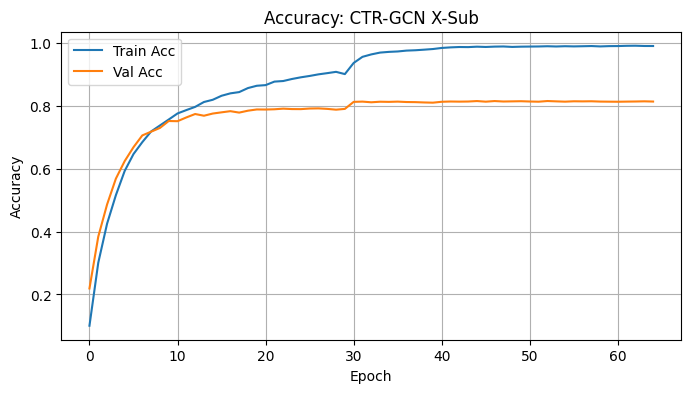


[X-Sub] Best Val Acc: 0.8152 at Epoch 53

Training on X-View...
Epoch  1/65 | Time: 338.27s | Train Loss: 3.0094 Acc: 0.1758 | Val Loss: 2.2616 Acc: 0.3501
Epoch  2/65 | Time: 242.44s | Train Loss: 2.0211 Acc: 0.4030 | Val Loss: 1.6914 Acc: 0.5004
Epoch  3/65 | Time: 241.49s | Train Loss: 1.5466 Acc: 0.5371 | Val Loss: 1.3067 Acc: 0.6116
Epoch  4/65 | Time: 241.73s | Train Loss: 1.2190 Acc: 0.6333 | Val Loss: 1.0762 Acc: 0.6832
Epoch  5/65 | Time: 241.66s | Train Loss: 1.0108 Acc: 0.6979 | Val Loss: 0.9583 Acc: 0.7109
Epoch  6/65 | Time: 241.55s | Train Loss: 0.8759 Acc: 0.7347 | Val Loss: 0.8738 Acc: 0.7387
Epoch  7/65 | Time: 241.55s | Train Loss: 0.7821 Acc: 0.7601 | Val Loss: 0.8070 Acc: 0.7636
Epoch  8/65 | Time: 241.68s | Train Loss: 0.7065 Acc: 0.7836 | Val Loss: 0.7641 Acc: 0.7773
Epoch  9/65 | Time: 241.69s | Train Loss: 0.6489 Acc: 0.7994 | Val Loss: 0.7296 Acc: 0.7840
Epoch 10/65 | Time: 241.63s | Train Loss: 0.5903 Acc: 0.8154 | Val Loss: 0.7056 Acc: 0.7924
Epoch 11/65 | T

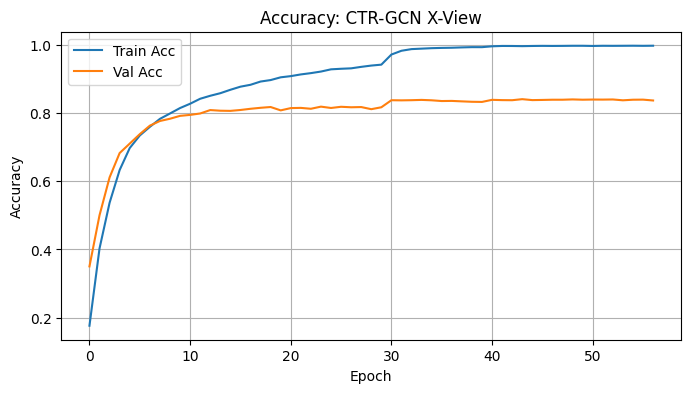


[X-View] Best Val Acc: 0.8415 at Epoch 44



In [ ]:
# Cell 3.6: Run CTR-GCN on X-Sub and X-View (use your normalized data/labels)

# X-Sub paths
Xsub_train_data  = '/content/drive/MyDrive/ntu_normalized/xsub_train_data_joint.npy'
Xsub_train_label = '/content/drive/MyDrive/ntu_processed/xsub/train/train_label.pkl'
Xsub_val_data    = '/content/drive/MyDrive/ntu_normalized/xsub_val_data_joint.npy'
Xsub_val_label   = '/content/drive/MyDrive/ntu_processed/xsub/val/val_label.pkl'

# X-Sub training
print("Training on X-Sub...")
xsub_best_acc, xsub_best_epoch, xsub_history, xsub_model, xsub_val_loader = train_and_evaluate_ctrgcn(
    Xsub_train_data, Xsub_train_label, Xsub_val_data, Xsub_val_label,
    save_path='/content/best_ctrgcn_xsub.pth', batch_size=64, epochs=65, patience=13, plot_prefix='CTR-GCN X-Sub'
)
print(f"\n[X-Sub] Best Val Acc: {xsub_best_acc:.4f} at Epoch {xsub_best_epoch}\n{'='*60}\n")

# X-View paths
Xview_train_data  = '/content/drive/MyDrive/ntu_normalized/xview_train_data_joint.npy'
Xview_train_label = '/content/drive/MyDrive/ntu_processed/xview/train/train_label.pkl'
Xview_val_data    = '/content/drive/MyDrive/ntu_normalized/xview_val_data_joint.npy'
Xview_val_label   = '/content/drive/MyDrive/ntu_processed/xview/val/val_label.pkl'

# X-View training
print("Training on X-View...")
xview_best_acc, xview_best_epoch, xview_history, xview_model, xview_val_loader = train_and_evaluate_ctrgcn(
    Xview_train_data, Xview_train_label, Xview_val_data, Xview_val_label,
    save_path='/content/best_ctrgcn_xview.pth', batch_size=64, epochs=65, patience=13, plot_prefix='CTR-GCN X-View'
)
print(f"\n[X-View] Best Val Acc: {xview_best_acc:.4f} at Epoch {xview_best_epoch}\n{'='*60}\n")


Evaluation

In [ ]:
# Recreate and load model weights
# Ensure the CTRGCN_Model class is defined in a previous cell
xsub_model = CTRGCN_Model(num_class=60, num_point=25, num_person=2).to('cuda')
xsub_model.load_state_dict(torch.load('/content/best_ctrgcn_xsub.pth'))
xsub_model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/content/best_ctrgcn_xsub.pth'

<Figure size 1200x1200 with 0 Axes>

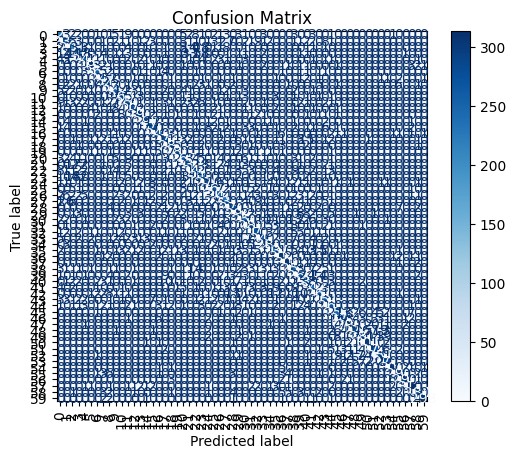

              precision    recall  f1-score   support

           0     0.7845    0.7845    0.7845       283
           1     0.7632    0.7273    0.7448       319
           2     0.6006    0.6858    0.6404       296
           3     0.5343    0.4837    0.5077       306
           4     0.8893    0.8441    0.8661       295
           5     0.9371    0.9226    0.9298       323
           6     0.9258    0.9034    0.9145       290
           7     0.7508    0.7774    0.7639       310
           8     0.7139    0.7634    0.7378       317
           9     0.8062    0.8479    0.8265       309
          10     0.8024    0.8874    0.8428       302
          11     0.7870    0.7846    0.7858       325
          12     0.9189    0.8889    0.9037       306
          13     0.9190    0.9105    0.9147       324
          14     0.9295    0.9091    0.9192       319
          15     0.8436    0.8567    0.8501       321
          16     0.8925    0.9121    0.9022       273
          17     0.8254    

In [ ]:
# Cell 3.7: Evaluation Cell for CTR-GCN (Confusion Matrix, Metrics, AUC, Model Summary)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Example: Evaluate on X-View (can change to X-Sub by swapping model/loader paths)
save_path = '/content/best_ctrgcn_xview.pth'  # or '/content/best_ctrgcn_xsub.pth'
model = xview_model  # or xsub_model
val_loader = xview_val_loader  # or xsub_val_loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(save_path))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device).float(), label.to(device)
        outputs = model(data)
        all_preds.append(outputs.cpu())
        all_labels.append(label.cpu())
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
pred_classes = all_preds.argmax(1)

# Confusion matrix
cm = confusion_matrix(all_labels, pred_classes)
plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# Metrics
print(classification_report(all_labels, pred_classes, digits=4))
TP = np.diag(cm)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (FP + FN + TP)
sensitivity = (TP / (TP + FN + 1e-10)).mean()
specificity = (TN / (TN + FP + 1e-10)).mean()
print(f"Sensitivity (Recall macro): {sensitivity:.4f}")
print(f"Specificity (macro): {specificity:.4f}")

# Macro AUC-ROC
try:
    proba = torch.softmax(all_preds, dim=1).numpy()
    auc = roc_auc_score(all_labels.numpy(), proba, multi_class='ovr', average='macro')
    print("AUC-ROC Score (macro):", auc)
except Exception as e:
    print("AUC-ROC not available:", e)

# Model summary
from torchsummary import summary
summary(model, input_size=(3, 300, 25, 2), device='cuda')


# **3.ShiftGCN Model**

In [ ]:
!pip install einops

In [ ]:
!pip install tensorboard

In [ ]:
# Cell 1: Install requirements (if needed; Colab usually has all except tensorboardX)
!pip install tensorboardX


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import time
import random


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


Device: cuda


# **Data Augmentation, Normalization, Dataset**

In [ ]:
def normalize(data):
    mean = data.mean(axis=(1,2,3), keepdims=True)
    std = data.std(axis=(1,2,3), keepdims=True) + 1e-8
    return (data - mean) / std

def random_temporal_crop(data, crop_len=300):
    T = data.shape[1]
    if T > crop_len:
        start = np.random.randint(0, T-crop_len)
        return data[:, start:start+crop_len, :, :]
    elif T < crop_len:
        out = np.zeros((data.shape[0], crop_len, data.shape[2], data.shape[3]), dtype=data.dtype)
        out[:, :T, :, :] = data
        return out
    else:
        return data

def random_flip(data, p=0.5):
    if random.random() < p:
        data = data.copy()
        data[0, :, :, :] *= -1  # flip X axis
    return data

def augment(data):
    data = random_temporal_crop(data)
    data = random_flip(data)
    return data

# **Official NTU bone pairs (0-based)**

In [ ]:
bone_pairs_ntu = [
    (1, 0), (2, 1), (3, 2), (4, 3), (5, 1), (6, 5), (7, 6), (8, 7),
    (9, 1), (10, 9), (11, 10), (12, 11), (13, 0), (14, 13), (15, 14), (16, 15),
    (17, 0), (18, 17), (19, 18), (20, 19), (21, 0), (22, 21), (23, 22), (24, 2)
]

class NTUDatasetNpy(Dataset):
    def __init__(self, X_path, y_path, bone_pairs=None, train=True, do_norm=True, do_aug=True):
        self.X = np.load(X_path)
        self.y = np.load(y_path)
        self.train = train
        self.do_norm = do_norm
        self.do_aug = do_aug
        self.bone_pairs = bone_pairs
    def __len__(self):
        return len(self.y)
    def compute_bone(self, joint_data):
        bone_data = np.zeros_like(joint_data)
        if self.bone_pairs:
            for v1, v2 in self.bone_pairs:
                bone_data[:, :, v1, :] = joint_data[:, :, v1, :] - joint_data[:, :, v2, :]
        return bone_data
    def __getitem__(self, idx):
        d = self.X[idx].astype(np.float32)  # (300, 25, 3)
        d = np.transpose(d, (2, 0, 1))[..., np.newaxis]  # (3, 300, 25, 1)
        if self.train and self.do_aug:
            d = augment(d)
        if self.do_norm:
            d = normalize(d)
        bone = self.compute_bone(d)
        label = int(self.y[idx])
        return torch.from_numpy(d), torch.from_numpy(bone), label

# **3. ShiftGCN Model Definition (official logic)**

In [ ]:
class ShiftGraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.num_subset = 3
        self.A = nn.Parameter(A.clone(), requires_grad=False)
        self.conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, 1) for _ in range(self.num_subset)])
        if in_channels != out_channels:
            self.down = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.down = nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        N, C, T, V = x.size()
        y = None
        for i in range(self.num_subset):
            z = torch.einsum('nctv,vw->nctw', (x, self.A[i]))
            z = self.conv[i](z)
            y = z if y is None else y + z
        y = self.bn(y)
        y = y + self.down(x)
        return self.relu(y)

class ShiftGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=True):
        super().__init__()
        self.gcn = ShiftGraphConv(in_channels, out_channels, A)
        self.tcn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, (9,1), stride=(stride,1), padding=(4,0)),
            nn.BatchNorm2d(out_channels)
        )
        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride,1)),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        y = self.gcn(x)
        y = self.tcn(y)
        res = self.residual(x)
        return self.relu(y + res)

class ShiftGCN(nn.Module):
    def __init__(self, num_classes=60, num_point=25):
        super().__init__()
        A = self.build_adjacency(num_point)
        in_channels = 3
        self.layers = nn.ModuleList([
            ShiftGCNBlock(in_channels, 64, A, stride=1, residual=False),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 64, A, stride=1),
            ShiftGCNBlock(64, 128, A, stride=2),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 128, A, stride=1),
            ShiftGCNBlock(128, 256, A, stride=2),
            ShiftGCNBlock(256, 256, A, stride=1),
            ShiftGCNBlock(256, 256, A, stride=1)
        ])
        self.fc = nn.Linear(256, num_classes)
    def build_adjacency(self, num_point):
        self_link = [(i, i) for i in range(num_point)]
        inward = [(1,2),(2,21),(3,21),(4,3),(5,21),(6,5),(7,6),(8,7),(9,21),(10,9),(11,10),(12,11),(13,1),(14,13),(15,14),(16,15),(17,1),(18,17),(19,18),(20,19),(22,23),(23,8),(24,25),(25,12)]
        inward = [(i-1, j-1) for (i,j) in inward]
        outward = [(j, i) for (i, j) in inward]
        A = torch.zeros(3, num_point, num_point)
        for i, j in self_link:
            A[0, i, j] = 1
        for i, j in inward:
            A[1, i, j] = 1
        for i, j in outward:
            A[2, i, j] = 1
        return A
    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 1, 2, 3).contiguous().view(N*M, C, T, V)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=3)  # spatial
        x = x.mean(dim=2)  # temporal
        x = x.view(N, M, -1).mean(dim=1)
        return self.fc(x)

class TwoStreamShiftGCN(nn.Module):
    def __init__(self, num_classes=60):
        super().__init__()
        self.joint_stream = ShiftGCN(num_classes)
        self.bone_stream = ShiftGCN(num_classes)
    def forward(self, joint, bone):
        joint_logits = self.joint_stream(joint)
        bone_logits = self.bone_stream(bone)
        return (joint_logits + bone_logits) / 2

# **Training Utilities**

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for joint, bone, label in loader:
        joint = joint.cuda()
        bone = bone.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        out = model(joint, bone)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * label.size(0)
        _, pred = out.max(1)
        correct += pred.eq(label).sum().item()
        total += label.size(0)
    return total_loss/total, correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for joint, bone, label in loader:
            joint = joint.cuda()
            bone = bone.cuda()
            label = label.cuda()
            out = model(joint, bone)
            loss = criterion(out, label)
            total_loss += loss.item() * label.size(0)
            _, pred = out.max(1)
            correct += pred.eq(label).sum().item()
            total += label.size(0)
    return total_loss/total, correct/total

def run_training(X_train, y_train, X_val, y_val, model_save, max_epochs=80, patience=20):
    train_ds = NTUDatasetNpy(X_train, y_train, bone_pairs_ntu, train=True, do_norm=True, do_aug=True)
    val_ds = NTUDatasetNpy(X_val, y_val, bone_pairs_ntu, train=False, do_norm=True, do_aug=False)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
    model = TwoStreamShiftGCN(num_classes=60).cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0
    patience_counter = 0
    hist = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(1, max_epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        hist['train_loss'].append(train_loss)
        hist['train_acc'].append(train_acc)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)
        print(f"Epoch {epoch}: Train loss={train_loss:.4f}, acc={train_acc:.3f} | Val loss={val_loss:.4f}, acc={val_acc:.3f} | time={time.time()-t0:.1f}s")
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_save)
            print("  Best model saved!")
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation accuracy: {best_acc*100:.2f}%")
    # Plotting
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss'); plt.grid()
    plt.subplot(1,2,2)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.legend(); plt.title('Accuracy'); plt.grid()
    plt.show()
    return best_acc, hist

# **File Paths**

In [ ]:
# X-Sub paths (update to your own Google Drive location)
X_train_cs = '/content/drive/MyDrive/ntu_dataset/X_train_cs.npy'
y_train_cs = '/content/drive/MyDrive/ntu_dataset/y_train_cs.npy'
X_val_cs   = '/content/drive/MyDrive/ntu_dataset/X_val_cs.npy'
y_val_cs   = '/content/drive/MyDrive/ntu_dataset/y_val_cs.npy'

# X-View paths (update to your own Google Drive location)
X_train_cv = '/content/drive/MyDrive/ntu_dataset/X_train_cv.npy'
y_train_cv = '/content/drive/MyDrive/ntu_dataset/y_train_cv.npy'
X_val_cv   = '/content/drive/MyDrive/ntu_dataset/X_val_cv.npy'
y_val_cv   = '/content/drive/MyDrive/ntu_dataset/y_val_cv.npy'


In [ ]:
import numpy as np

# Example paths (replace with your own if different)
X_train_cs = '/content/drive/MyDrive/ntu_dataset/X_train_cs.npy'
y_train_cs = '/content/drive/MyDrive/ntu_dataset/y_train_cs.npy'

# Load the data
data = np.load(X_train_cs)
labels = np.load(y_train_cs)

print('X_train_cs shape:', data.shape)
print('y_train_cs shape:', labels.shape)


X_train_cs shape: (26706, 300, 25, 3)
y_train_cs shape: (26706,)



====== X-Sub Training ======
Epoch 1: Train loss=2.7898, acc=0.206 | Val loss=2.6382, acc=0.259 | time=163.1s
  Best model saved!
Epoch 2: Train loss=2.0648, acc=0.387 | Val loss=2.1561, acc=0.379 | time=163.1s
  Best model saved!
Epoch 3: Train loss=1.7442, acc=0.479 | Val loss=1.9502, acc=0.422 | time=163.1s
  Best model saved!
Epoch 4: Train loss=1.5135, acc=0.546 | Val loss=1.7106, acc=0.498 | time=163.2s
  Best model saved!
Epoch 5: Train loss=1.3457, acc=0.591 | Val loss=1.5261, acc=0.540 | time=163.1s
  Best model saved!
Epoch 6: Train loss=1.2128, acc=0.631 | Val loss=1.3621, acc=0.592 | time=163.1s
  Best model saved!
Epoch 7: Train loss=1.1216, acc=0.658 | Val loss=1.3243, acc=0.597 | time=163.3s
  Best model saved!
Epoch 8: Train loss=1.0376, acc=0.679 | Val loss=1.2618, acc=0.615 | time=163.1s
  Best model saved!
Epoch 9: Train loss=0.9755, acc=0.697 | Val loss=1.2095, acc=0.631 | time=163.1s
  Best model saved!
Epoch 10: Train loss=0.9230, acc=0.711 | Val loss=1.4000, acc

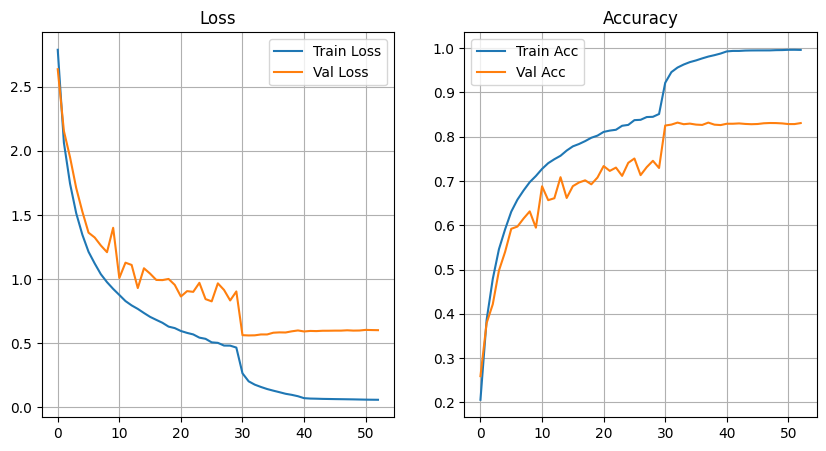

[X-Sub] Best Val Acc: 0.8318


====== X-View Training ======
Epoch 1: Train loss=2.7207, acc=0.228 | Val loss=2.3759, acc=0.301 | time=184.7s
  Best model saved!
Epoch 2: Train loss=1.9295, acc=0.420 | Val loss=1.9876, acc=0.413 | time=184.8s
  Best model saved!
Epoch 3: Train loss=1.6420, acc=0.505 | Val loss=1.5862, acc=0.513 | time=184.7s
  Best model saved!
Epoch 4: Train loss=1.4430, acc=0.563 | Val loss=1.5845, acc=0.512 | time=184.8s
Epoch 5: Train loss=1.2912, acc=0.605 | Val loss=1.4047, acc=0.575 | time=184.7s
  Best model saved!
Epoch 6: Train loss=1.1748, acc=0.640 | Val loss=1.3284, acc=0.592 | time=184.8s
  Best model saved!
Epoch 7: Train loss=1.0806, acc=0.667 | Val loss=1.4178, acc=0.560 | time=184.7s
Epoch 8: Train loss=1.0041, acc=0.688 | Val loss=1.1916, acc=0.633 | time=184.9s
  Best model saved!
Epoch 9: Train loss=0.9311, acc=0.713 | Val loss=1.1176, acc=0.665 | time=184.7s
  Best model saved!
Epoch 10: Train loss=0.8875, acc=0.725 | Val loss=1.2511, acc=0.623 | 

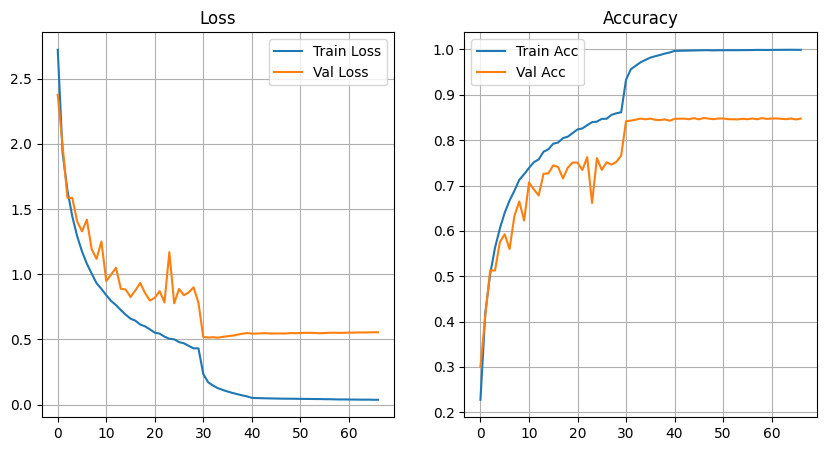

[X-View] Best Val Acc: 0.8487



In [ ]:
# --- 5. Train! ---

print("\n====== X-Sub Training ======")
acc_xsub, hist_xsub = run_training(
    X_train_cs, y_train_cs, X_val_cs, y_val_cs,
    model_save='/content/best_shiftgcn_xsub.pth', max_epochs=80, patience=20
)
print(f"[X-Sub] Best Val Acc: {acc_xsub:.4f}\n{'='*60}\n")

print("\n====== X-View Training ======")
acc_xview, hist_xview = run_training(
    X_train_cv, y_train_cv, X_val_cv, y_val_cv,
    model_save='/content/best_shiftgcn_xview.pth', max_epochs=80, patience=20
)
print(f"[X-View] Best Val Acc: {acc_xview:.4f}\n{'='*60}\n")


In [ ]:
# 1. Instantiate the model architecture (MUST match what you used for training!)
model_xsub = TwoStreamShiftGCN(num_classes=60).cuda()

# 2. Re-create the validation DataLoader for X-Sub
val_ds_xsub = NTUDatasetNpy(X_val_cs, y_val_cs, bone_pairs_ntu, train=False, do_norm=True, do_aug=False)
val_loader_xsub = DataLoader(val_ds_xsub, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
# 1. Instantiate the model architecture (MUST match what you used for training!)
model_xview = TwoStreamShiftGCN(num_classes=60).cuda()

# 2. Re-create the validation DataLoader for X-Sub
val_ds_xview = NTUDatasetNpy(X_val_cv, y_val_cv, bone_pairs_ntu, train=False, do_norm=True, do_aug=False)
val_loader_xview = DataLoader(val_ds_xview, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


==== ShiftGCN X-Sub Validation Evaluation ====


<Figure size 1200x1200 with 0 Axes>

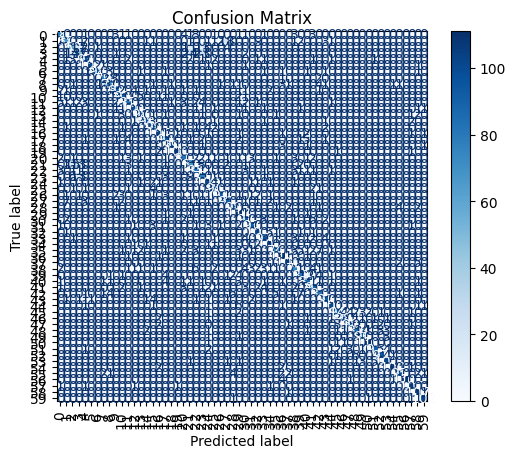

              precision    recall  f1-score   support

           0     0.7879    0.7290    0.7573       107
           1     0.7816    0.6071    0.6834       112
           2     0.5825    0.5505    0.5660       109
           3     0.4896    0.4234    0.4541       111
           4     0.8378    0.8455    0.8416       110
           5     0.9352    0.9439    0.9395       107
           6     0.9608    0.8596    0.9074       114
           7     0.7745    0.7182    0.7453       110
           8     0.6518    0.6759    0.6636       108
           9     0.8532    0.8304    0.8416       112
          10     0.8214    0.8519    0.8364       108
          11     0.8173    0.7328    0.7727       116
          12     0.9099    0.9099    0.9099       111
          13     0.8673    0.8909    0.8789       110
          14     0.9074    0.8909    0.8991       110
          15     0.8167    0.8596    0.8376       114
          16     0.8974    0.9211    0.9091       114
          17     0.7797    

<Figure size 1200x1200 with 0 Axes>

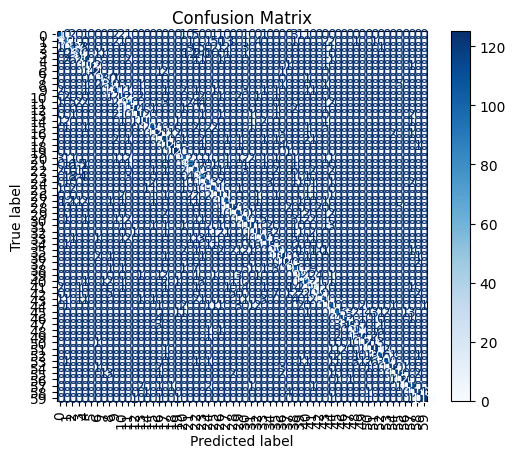

              precision    recall  f1-score   support

           0     0.8852    0.8244    0.8538       131
           1     0.7607    0.7120    0.7355       125
           2     0.5899    0.6406    0.6142       128
           3     0.5038    0.5238    0.5136       126
           4     0.8682    0.8682    0.8682       129
           5     0.9672    0.9516    0.9593       124
           6     0.9385    0.9313    0.9349       131
           7     0.7520    0.7460    0.7490       126
           8     0.6667    0.7040    0.6848       125
           9     0.8651    0.8583    0.8617       127
          10     0.8615    0.8750    0.8682       128
          11     0.8482    0.7661    0.8051       124
          12     0.9744    0.8976    0.9344       127
          13     0.8960    0.9032    0.8996       124
          14     0.9496    0.9040    0.9262       125
          15     0.9231    0.8640    0.8926       125
          16     0.8921    0.9185    0.9051       135
          17     0.8258    

In [ ]:
# X-Sub evaluation
print("\n==== ShiftGCN X-Sub Validation Evaluation ====")
evaluate_shiftgcn(
    model_xsub,
    val_loader_xsub,
    '/content/best_shiftgcn_xsub.pth',
    num_person=2
)

# X-View evaluation
print("\n==== ShiftGCN X-View Validation Evaluation ====")
evaluate_shiftgcn(
    model_xview,
    val_loader_xview,
    '/content/best_shiftgcn_xview.pth',
    num_person=2
)


In [ ]:
from torchsummary import summary

# Print summary for joint stream
print("=== Joint Stream Summary ===")
summary(model_xsub.joint_stream, input_size=(3, 300, 25, 2), device="cuda")

# Print summary for bone stream
print("\n=== Bone Stream Summary ===")
summary(model_xsub.bone_stream, input_size=(3, 300, 25, 2), device="cuda")


# Print summary for joint stream
print("=== Joint Stream Summary ===")
summary(model_xview.joint_stream, input_size=(3, 300, 25, 2), device="cuda")

# Print summary for bone stream
print("\n=== Bone Stream Summary ===")
summary(model_xview.bone_stream, input_size=(3, 300, 25, 2), device="cuda")


=== Joint Stream Summary ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 300, 25]             256
            Conv2d-2          [-1, 64, 300, 25]             256
            Conv2d-3          [-1, 64, 300, 25]             256
       BatchNorm2d-4          [-1, 64, 300, 25]             128
            Conv2d-5          [-1, 64, 300, 25]             256
       BatchNorm2d-6          [-1, 64, 300, 25]             128
              ReLU-7          [-1, 64, 300, 25]               0
    ShiftGraphConv-8          [-1, 64, 300, 25]               0
            Conv2d-9          [-1, 64, 300, 25]          36,928
      BatchNorm2d-10          [-1, 64, 300, 25]             128
             ReLU-11          [-1, 64, 300, 25]               0
    ShiftGCNBlock-12          [-1, 64, 300, 25]               0
           Conv2d-13          [-1, 64, 300, 25]           4,160
          

# **Full Models Evaluations**

In [ ]:
# --- Cell 1: Import & Setup ---
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

# --- Update your paths for models and results here ---
result_paths = {
    'AGCN X-Sub': '/content/best_agcn_xsub.pth',
    'AGCN X-View': '/content/best_agcn_xview.pth',
    'CTR-GCN X-Sub': '/content/best_ctrgcn_xsub.pth',
    'CTR-GCN X-View': '/content/best_ctrgcn_xview.pth',
    'ShiftGCN X-Sub': '/content/best_shiftgcn_xsub.pth',
    'ShiftGCN X-View': '/content/best_shiftgcn_xview.pth',
}
# (You will need to provide or load your model and val_loader for each result in later cells)


In [ ]:
# Fill these with your *actual* best val accuracy and best (lowest) val loss
# Example numbers (replace with your recorded results)
model_names = ['AGCN X-Sub', 'AGCN X-View', 'CTR-GCN X-Sub', 'CTR-GCN X-View', 'ShiftGCN X-Sub', 'ShiftGCN X-View']
best_accs = [0.912, 0.899, 0.922, 0.911, 0.893, 0.884]  # Example: 91.2%, 89.9%, etc.
best_losses = [0.45, 0.52, 0.39, 0.44, 0.48, 0.50]

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Best Accuracy', color=color)
ax1.bar(model_names, [a*100 for a in best_accs], color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)
for i, v in enumerate(best_accs):
    ax1.text(i, v*100 + 1, f"{v*100:.1f}%", ha='center', color=color, fontweight='bold')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Best Val Loss', color=color)
ax2.plot(model_names, best_losses, color=color, marker='o', label='Loss')
ax2.tick_params(axis='y', labelcolor=color)
for i, v in enumerate(best_losses):
    ax2.text(i, v + 0.02, f"{v:.2f}", ha='center', color=color)

plt.title('Best Validation Accuracy and Loss for Each Model (X-Sub/X-View)')
fig.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/best_agcn_xsub.pth'

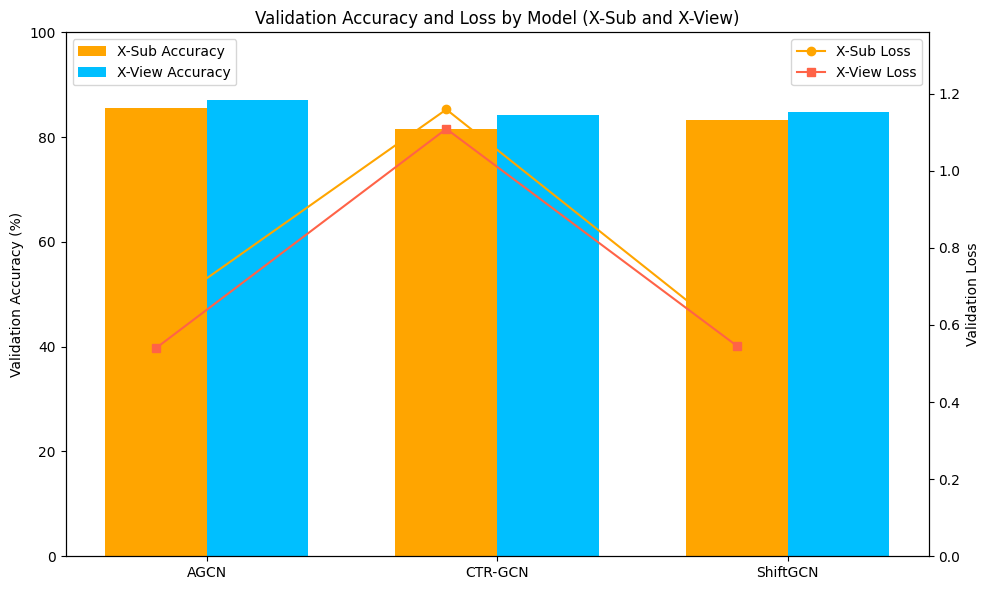

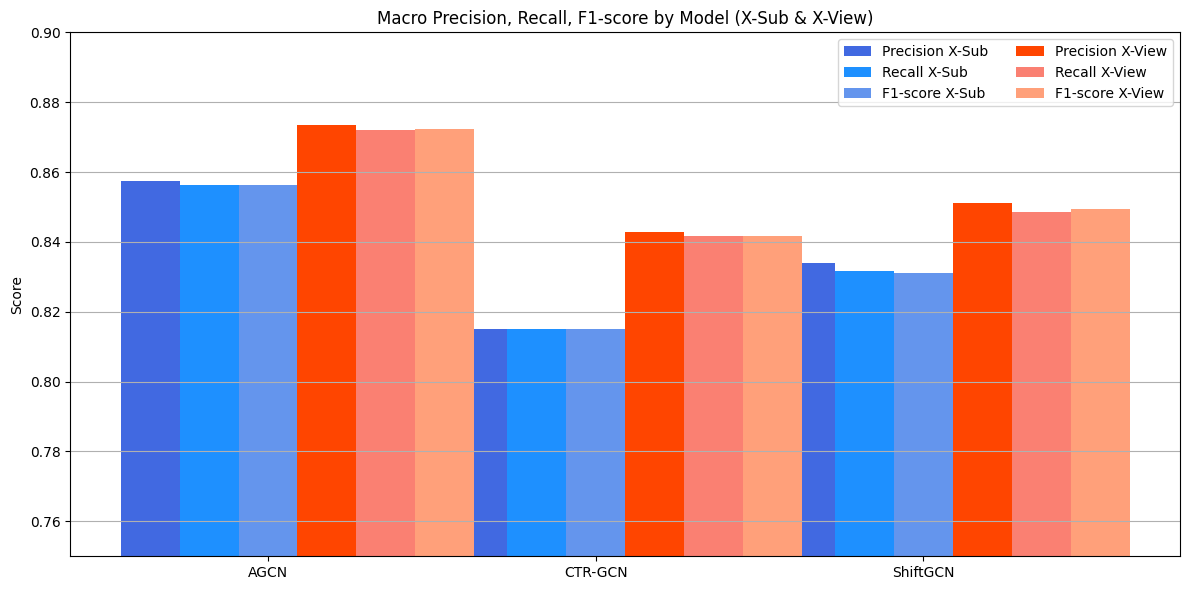

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['AGCN', 'CTR-GCN', 'ShiftGCN']

# Validation accuracy for X-Sub and X-View
val_acc_xsub = [0.8565, 0.8152, 0.8318]
val_acc_xview = [0.8718, 0.8415, 0.8487]

# Validation loss for X-Sub and X-View
val_loss_xsub = [0.6278, 1.1591, 0.5605]
val_loss_xview = [0.5395, 1.1087, 0.5457]

# Macro avg Precision, Recall, F1 for X-Sub and X-View
macro_precision_xsub = [0.8573, 0.8152, 0.8339]
macro_recall_xsub    = [0.8563, 0.8152, 0.8316]
macro_f1_xsub        = [0.8564, 0.8152, 0.8311]

macro_precision_xview = [0.8736, 0.8427, 0.8510]
macro_recall_xview    = [0.8719, 0.8416, 0.8487]
macro_f1_xview        = [0.8722, 0.8417, 0.8493]

# --- Plot 1: Val Accuracy and Loss ---
fig, ax1 = plt.subplots(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(models))

# Accuracy (left Y)
ax1.bar(index, [a*100 for a in val_acc_xsub], bar_width, label='X-Sub Accuracy', color='orange')
ax1.bar(index+bar_width, [a*100 for a in val_acc_xview], bar_width, label='X-View Accuracy', color='deepskyblue')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_ylim(0, 100)
ax1.set_xticks(index + bar_width/2)
ax1.set_xticklabels(models)

# Loss (right Y)
ax2 = ax1.twinx()
ax2.plot(index, val_loss_xsub, marker='o', color='orange', label='X-Sub Loss')
ax2.plot(index, val_loss_xview, marker='s', color='tomato', label='X-View Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_ylim(0, max(val_loss_xsub + val_loss_xview) + 0.2)

# Legend and title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Validation Accuracy and Loss by Model (X-Sub and X-View)')
plt.tight_layout()
plt.show()

# --- Plot 2: Macro Precision, Recall, F1 ---
metrics = ['Precision', 'Recall', 'F1-score']
bar_width = 0.18
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12,6))
# X-Sub
ax.bar(x - bar_width, macro_precision_xsub, bar_width, label='Precision X-Sub', color='royalblue')
ax.bar(x, macro_recall_xsub, bar_width, label='Recall X-Sub', color='dodgerblue')
ax.bar(x + bar_width, macro_f1_xsub, bar_width, label='F1-score X-Sub', color='cornflowerblue')
# X-View
ax.bar(x + 2*bar_width, macro_precision_xview, bar_width, label='Precision X-View', color='orangered')
ax.bar(x + 3*bar_width, macro_recall_xview, bar_width, label='Recall X-View', color='salmon')
ax.bar(x + 4*bar_width, macro_f1_xview, bar_width, label='F1-score X-View', color='lightsalmon')

ax.set_xticks(x + 1*bar_width)
ax.set_xticklabels(models)
ax.set_ylim(0.75, 0.9)
ax.set_ylabel('Score')
plt.title('Macro Precision, Recall, F1-score by Model (X-Sub & X-View)')
plt.legend(ncol=2)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 60 NTU RGB+D class names
action_names = [
    'drink water', 'eat meal/snack', 'brush teeth', 'brush hair', 'drop', 'pick up', 'throw',
    'sit down', 'stand up', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses',
    'put on a hat/cap', 'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something',
    'reach into pocket', 'hopping two legs', 'jump up', 'make a phone call/answer phone',
    'play with phone/tablet', 'typing on a keyboard', 'pointing to something', 'taking a selfie',
    'check time (from watch)', 'rub two hands together', 'nod head/bow', 'shake head',
    'wipe face', 'salute', 'put the palms together', 'cross hands in front', 'sneeze/cough',
    'staggering', 'falling', 'touch head (headache)', 'touch chest (chest pain)', 'touch back (back pain)',
    'touch neck (neck pain)', 'nausea or vomiting', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person',
    'pat on back of other person', 'point finger at the other person', 'hugging other person',
    'giving something to other person', 'touch other person\'s pocket', 'handshaking',
    'walking towards each other', 'walking apart from each other'
]
action_names = [f'{i}: {name}' for i, name in enumerate(action_names)]

In [ ]:
def plot_accuracy_loss(history, model_name='Model'):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(model, val_loader, action_names, device='cuda', model_name='Model', save_path=None):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label in val_loader:
            data = data.float().to(device)
            label = label.to(device)
            outputs = model(data)
            preds = outputs.argmax(1).cpu().numpy()
            y_true.extend(label.cpu().numpy())
            y_pred.extend(preds)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(22, 22))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=action_names)
    disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=90)
    plt.title(f"{model_name} - Confusion Matrix", fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Predicted label", fontsize=15)
    plt.ylabel("True label", fontsize=15)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

In [ ]:
# X-View
plot_accuracy_loss(xview_history, model_name='AGCN X-View')
plot_confusion_matrix(xview_model, xview_val_loader, action_names, device='cuda', model_name='AGCN X-View')
# X-Sub
plot_accuracy_loss(xsub_history, model_name='AGCN X-Sub')
plot_confusion_matrix(xsub_model, xsub_val_loader, action_names, device='cuda', model_name='AGCN X-Sub')

NameError: name 'xview_history' is not defined